In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(0)

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

In [2]:
df = pd.read_csv("COVID_dataset.csv")

In [3]:
df.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70s,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,50s,FEMALE,NO KNOWN EPI LINK,Newmarket,NaN,44.048023,-79.480239,Not Resolved
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,70s,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Resolved
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,<20,MALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60s,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved


## Preprocessing:

In [4]:
#Missing information:
df.isnull().sum()

Accurate_Episode_Date         0
Case_Reported_Date            0
Test_Reported_Date          203
Specimen_Date               122
Age_Group                     5
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           9082
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
Outcome1                      0
dtype: int64

In [5]:
df.Client_Gender.value_counts()

FEMALE            7562
MALE              7192
UNSPECIFIED        105
GENDER DIVERSE       1
Name: Client_Gender, dtype: int64

In [6]:
df.Case_AcquisitionInfo.value_counts()

OB                      5371
CC                      4121
MISSING INFORMATION     2929
NO KNOWN EPI LINK       2242
TRAVEL                   192
UNSPECIFIED EPI LINK       5
Name: Case_AcquisitionInfo, dtype: int64

In [7]:
#Fill Outbreak related NaNs with 0 and replace 'Yes' with 1:
df['Outbreak_Related'] = df['Outbreak_Related'].fillna('No')
Outbreak_Related_map = {'Yes':1,'No':0}
df = df.replace({"Outbreak_Related":Outbreak_Related_map})
df['Outbreak_Related'] = df['Outbreak_Related'].astype('float32')

#As GENDER DIVERSE is an outlier,(also, there are only the other three types of client_gender in kaggle_data):
#Delete row with gender diverse entry
df = df[df.Client_Gender != 'GENDER DIVERSE']

#As UNSPECIFIED EPI LINK is an outlier,(also, there are only the other three types of Case_AcquisitionInfo in kaggle_data):
#Delete row with UNSPECIFIED EPI LINK entry
df = df[df.Case_AcquisitionInfo != 'UNSPECIFIED EPI LINK']

In [8]:
#Reset the index after dropping rows:
df = df.reset_index(drop=True)

In [9]:
#Since missing date information cannot be filled, drop test_reported_date and specimen date:
df = df.drop(columns=['Test_Reported_Date','Specimen_Date'])

In [10]:
#Checking stats to fill in age_group missing values:
df.Age_Group.describe()

count     14849
unique        9
top         80s
freq       2201
Name: Age_Group, dtype: object

In [11]:
#Replace Age_Group string values with ordinal values:
Age_Group_map = {'<20':1,'20s':2,'30s':3,'40s':4,'50s':5,'60s':6,'70s':7,'80s':8,'90s':9}
df = df.replace({"Age_Group":Age_Group_map})

#Randomly fill missing age_group values with integers in {5,6,7,8} (5 missing values): 
df['Age_Group'] = df['Age_Group'].fillna(random.randint(5,8))
df['Age_Group'] = df['Age_Group'].astype(str) #for indicator feature column

In [12]:
#Converting datetime columns to unix timestamp (in days)
for i in range(len(df)):
    df.loc[i,['Accurate_Episode_Date']]=(pd.Timestamp(df['Accurate_Episode_Date'][i])
                                         -pd.Timestamp("1970-01-01"))//pd.Timedelta('1d')
    df.loc[i,['Case_Reported_Date']] = (pd.Timestamp(df['Case_Reported_Date'][i])
                                        -pd.Timestamp("1970-01-01"))//pd.Timedelta('1d')

In [13]:
#Copying the dataframe and making the outcome column numerical for some EDA (at the end)
df1 = df
outcome_map = {'Fatal':0,'Resolved':1,'Not Resolved':2}
df1 = df1.replace({"Outcome1":outcome_map})
#Reshape outcome variable into three binary outcomes:
df = pd.get_dummies(df,prefix='Outcome1',columns=['Outcome1'])

In [14]:
#Splitting Training, Validation and Testing sets:
y = df.loc[:,['Outcome1_Fatal','Outcome1_Resolved','Outcome1_Not Resolved']]
X = df.drop(columns=['Outcome1_Fatal','Outcome1_Resolved','Outcome1_Not Resolved'])

from sklearn.model_selection import train_test_split
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.25, random_state=0)

## Using feature columns:

In [15]:
feature_columns1 = []

# numeric columns
for header in ['Accurate_Episode_Date', 'Case_Reported_Date','Outbreak_Related']:
  feature_columns1.append(feature_column.numeric_column(header))

latitude = feature_column.numeric_column('Reporting_PHU_Latitude')
longitude = feature_column.numeric_column('Reporting_PHU_Longitude')

In [16]:
# indicator columns
indicator_column_names = ['Age_Group', 'Client_Gender', 'Case_AcquisitionInfo','Reporting_PHU_City']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, df[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns1.append(indicator_column)

In [17]:
# bucketized columns
bucket_latitude = feature_column.bucketized_column(latitude, boundaries=np.linspace(42.5,49.5,51).tolist())
bucket_longitude = feature_column.bucketized_column(longitude, boundaries=np.linspace(-94.0,-74.5,51).tolist())

In [18]:
# crossed columns
coordinate_feature = feature_column.crossed_column([bucket_latitude, bucket_longitude], hash_bucket_size=50)
feature_columns1.append(feature_column.indicator_column(coordinate_feature))

In [19]:
# Method to go from dataframe to tf dataset:
def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = labels
  ds = tf.data.Dataset.from_tensor_slices((dataframe.to_dict(orient='list'), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [20]:
#Defining the feature layer:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns1)

In [21]:
batch_size = 32
train_ds = df_to_dataset(X_train, y_train, batch_size=batch_size)
val_ds = df_to_dataset(X_val, y_val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=batch_size)

# DNN:## Testing width and depth of network:

In [22]:
results_layer = []
for i in [4,5,6,7]:
    for j in [2,3,4]:
        if (j == 2):
            #Defining, Compiling and Training the model:
            model = tf.keras.Sequential([
                feature_layer,
                layers.BatchNormalization(),
                layers.Dense(2^i, activation='relu'),
                layers.Dense(8, activation='relu'),
                layers.Dense(3, activation='softmax')
            ])
        elif (j == 3):
            model = tf.keras.Sequential([
                feature_layer,
                layers.BatchNormalization(),
                layers.Dense(2^i, activation='relu'),
                layers.Dense(2^i, activation='relu'),
                layers.Dense(8, activation='relu'),
                layers.Dense(3, activation='softmax')
            ])
        else:
            model = tf.keras.Sequential([
                feature_layer,
                layers.BatchNormalization(),
                layers.Dense(2^i, activation='relu'),
                layers.Dense(2^i, activation='relu'),
                layers.Dense(2^i, activation='relu'),
                layers.Dense(8, activation='relu'),
                layers.Dense(3, activation='softmax')
            ])

        optimizer = keras.optimizers.Adam()

        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=15, 
                  verbose = 0)
        results_layer.append(history)

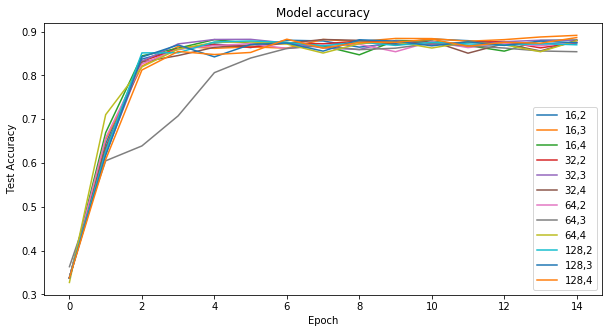

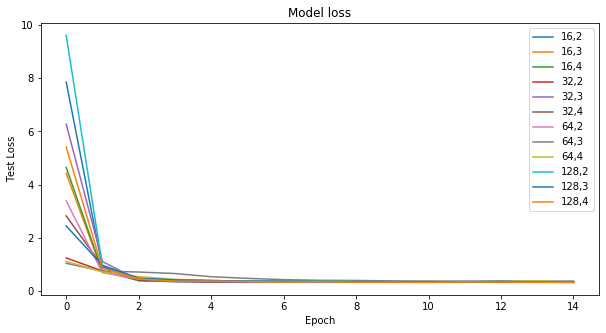

In [54]:
plt.figure(figsize=(10,5))
for act in results_layer:
    plt.plot(act.history["val_accuracy"])
    
plt.title('Model accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend(['16,2','16,3','16,4','32,2','32,3','32,4','64,2','64,3','64,4','128,2','128,3','128,4'])
plt.show()


plt.figure(figsize=(10,5))
for ast in results_layer:
    plt.plot(ast.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend(['16,2','16,3','16,4','32,2','32,3','32,4','64,2','64,3','64,4','128,2','128,3','128,4'])
plt.show()

## Testing Activation Function:

In [24]:
results_act = []
for i in ['relu','elu','sigmoid']:
    #Defining, Compiling and Training the model:
    model = tf.keras.Sequential([
        feature_layer,
        layers.BatchNormalization(),
        layers.Dense(32, activation=i),
        layers.Dense(32, activation=i),
        layers.Dense(8, activation=i),
        layers.Dense(3, activation='softmax')
    ])
        
    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=50, 
              verbose = 0)
    results_act.append(history)

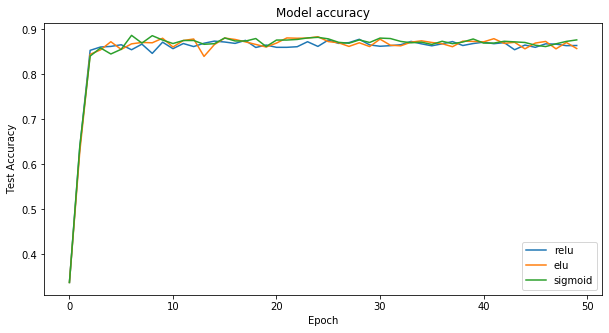

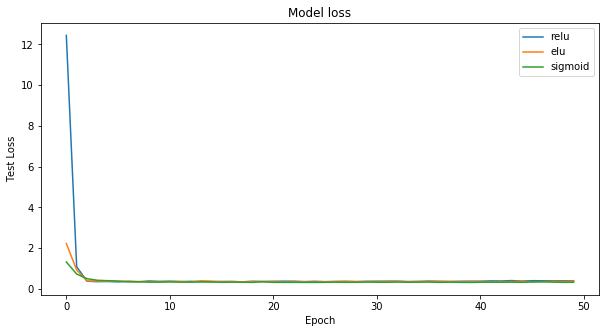

In [55]:
plt.figure(figsize=(10,5))
for act in results_act:
    plt.plot(act.history["val_accuracy"])
    
plt.title('Model accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend(['relu','elu','sigmoid'])
plt.show()


plt.figure(figsize=(10,5))
for ast in results_act:
    plt.plot(ast.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend(['relu','elu','sigmoid'])
plt.show()

## Testing Regularizer:

In [97]:
results_reg = []
for i in ['l1','l2','l1_l2']:
    #Defining, Compiling and Training the model:
    model = tf.keras.Sequential([
        feature_layer,
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_regularizer=i),
        layers.Dense(32, activation='relu', kernel_regularizer=i),
        layers.Dense(8, activation='relu', kernel_regularizer=i),
        layers.Dense(3, activation='softmax')
    ])
        
    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=30, 
              verbose = 0)
    results_reg.append(history)
    
for i in [0.1,0.2,0.4]:
    #Defining, Compiling and Training the model:
    model = tf.keras.Sequential([
        feature_layer,
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(i),
        layers.Dense(32, activation='relu'),
        layers.Dropout(i),
        layers.Dense(8, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
        
    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=30, 
              verbose = 0)
    results_reg.append(history)

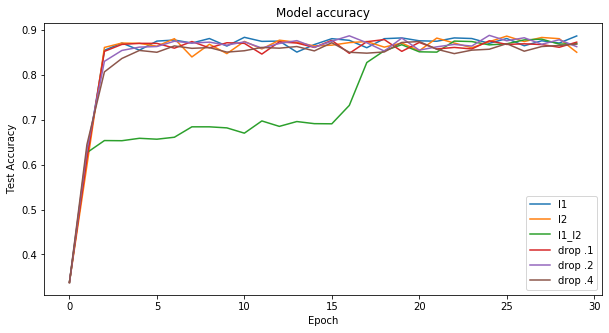

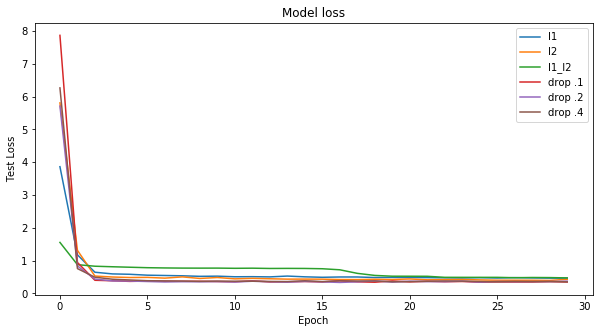

In [99]:
plt.figure(figsize=(10,5))
for act in results_reg:
    plt.plot(act.history["val_accuracy"])
    
plt.title('Model accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend(['l1','l2','l1_l2','drop .1','drop .2','drop .4'])
plt.show()


plt.figure(figsize=(10,5))
for ast in results_reg:
    plt.plot(ast.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend(['l1','l2','l1_l2','drop .1','drop .2','drop .4'])
plt.show()

In [100]:
results_regl1 = []
for i in [0,0.001,0.01,0.1]:
    #Defining, Compiling and Training the model:
    L1 = tf.keras.regularizers.l1(l1=i)
    model = tf.keras.Sequential([
        feature_layer,
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_regularizer=L1),
        layers.Dense(32, activation='relu', kernel_regularizer=L1),
        layers.Dense(8, activation='relu', kernel_regularizer=L1),
        layers.Dense(3, activation='softmax')
    ])
        
    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=30, 
              verbose = 0)
    results_regl1.append(history)

results_regl2 = []
for i in [0,0.001,0.01,0.1]:
    #Defining, Compiling and Training the model:
    L1 = tf.keras.regularizers.l2(l2=i)
    model = tf.keras.Sequential([
        feature_layer,
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_regularizer=L1),
        layers.Dense(32, activation='relu', kernel_regularizer=L1),
        layers.Dense(8, activation='relu', kernel_regularizer=L1),
        layers.Dense(3, activation='softmax')
    ])
        
    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=30, 
              verbose = 0)
    results_regl2.append(history)

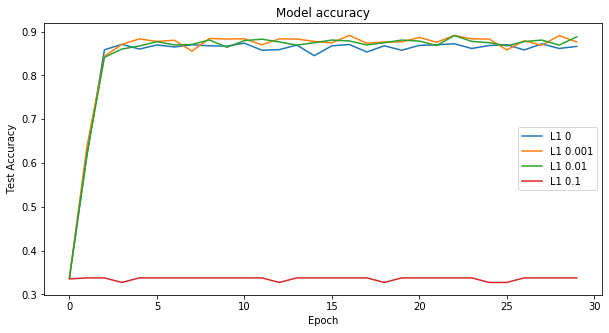

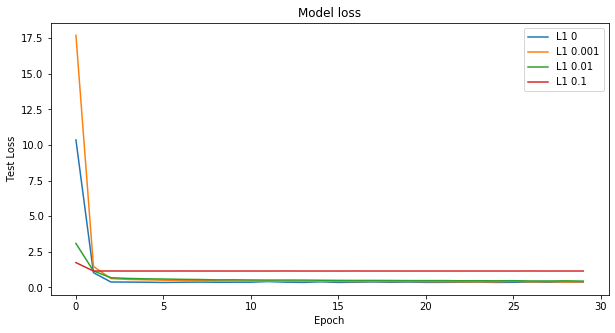

In [101]:
plt.figure(figsize=(10,5))
for act in results_regl1:
    plt.plot(act.history["val_accuracy"])
    
plt.title('Model accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend(['L1 0','L1 0.001','L1 0.01','L1 0.1'])
plt.show()


plt.figure(figsize=(10,5))
for ast in results_regl1:
    plt.plot(ast.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend(['L1 0','L1 0.001','L1 0.01','L1 0.1'])
plt.show()

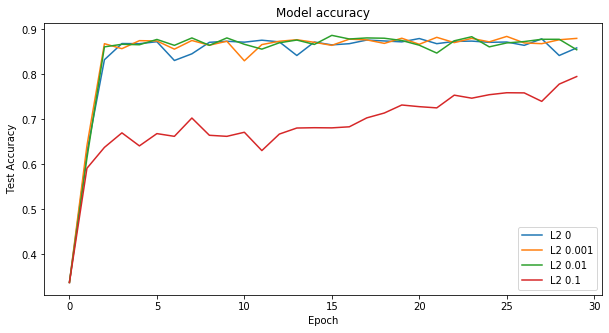

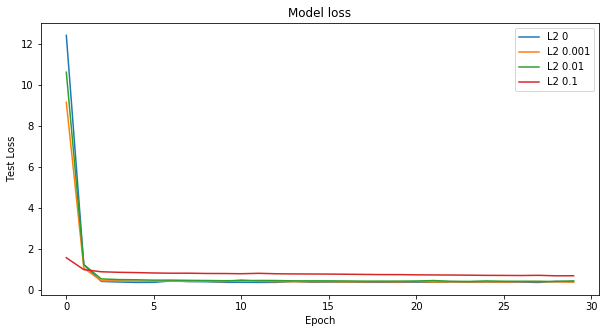

In [102]:
plt.figure(figsize=(10,5))
for act in results_regl2:
    plt.plot(act.history["val_accuracy"])
    
plt.title('Model accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend(['L2 0','L2 0.001','L2 0.01','L2 0.1'])
plt.show()


plt.figure(figsize=(10,5))
for ast in results_regl2:
    plt.plot(ast.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend(['L2 0','L2 0.001','L2 0.01','L2 0.1'])
plt.show()

## Final Feed Forward Neural Network (Model training, testing):

In [131]:
import tensorflow.keras.backend as K
K.clear_session()

#Defining, Compiling and Training the model:
model = tf.keras.Sequential([
    feature_layer,
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(3, activation='softmax')
])

optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, min_delta=0.05)

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=100, 
          verbose = 2, 
          callbacks = es)

results = []
results.append(history)

Epoch 1/100
279/279 - 6s - loss: 0.7663 - accuracy: 0.6465 - val_loss: 13.7826 - val_accuracy: 0.3376
Epoch 2/100
279/279 - 1s - loss: 0.4801 - accuracy: 0.8113 - val_loss: 1.3498 - val_accuracy: 0.6096
Epoch 3/100
279/279 - 1s - loss: 0.4349 - accuracy: 0.8298 - val_loss: 0.3936 - val_accuracy: 0.8657
Epoch 4/100
279/279 - 1s - loss: 0.4333 - accuracy: 0.8282 - val_loss: 0.3911 - val_accuracy: 0.8748
Epoch 5/100
279/279 - 1s - loss: 0.4244 - accuracy: 0.8393 - val_loss: 0.3696 - val_accuracy: 0.8755
Epoch 6/100
279/279 - 1s - loss: 0.4095 - accuracy: 0.8390 - val_loss: 0.3583 - val_accuracy: 0.8745
Epoch 7/100
279/279 - 1s - loss: 0.4142 - accuracy: 0.8384 - val_loss: 0.3857 - val_accuracy: 0.8657
Epoch 8/100
279/279 - 1s - loss: 0.4093 - accuracy: 0.8407 - val_loss: 0.3746 - val_accuracy: 0.8711
Epoch 9/100
279/279 - 1s - loss: 0.4101 - accuracy: 0.8352 - val_loss: 0.3690 - val_accuracy: 0.8761
Epoch 10/100
279/279 - 1s - loss: 0.3909 - accuracy: 0.8456 - val_loss: 0.3944 - val_accur

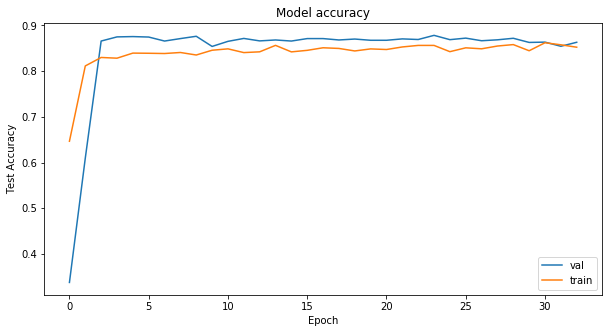

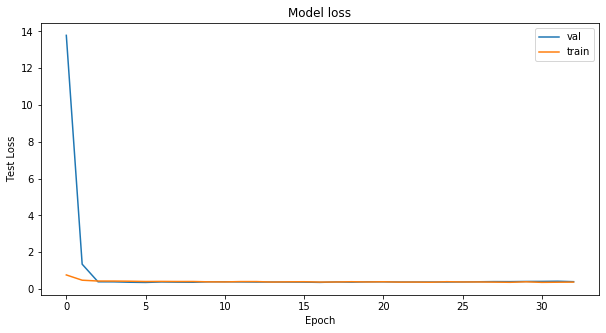

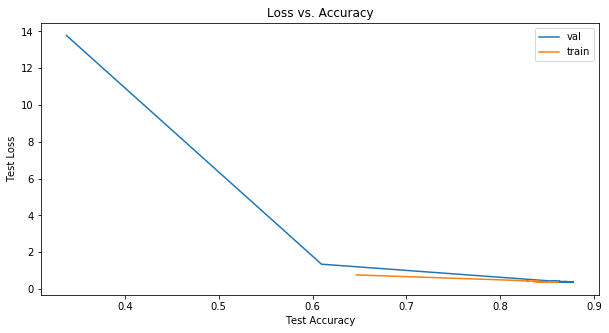

In [132]:
plt.figure(figsize=(10,5))
for act in results:
    plt.plot(act.history["val_accuracy"])
    plt.plot(act.history["accuracy"])
    
plt.title('Model accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend(['val','train'])
plt.show()


plt.figure(figsize=(10,5))
for ast in results:
    plt.plot(ast.history['val_loss'])
    plt.plot(act.history["loss"])
    
plt.title('Model loss')
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend(['val','train'])
plt.show()

plt.figure(figsize=(10,5))
for ast in results:
    plt.plot(act.history["val_accuracy"], ast.history['val_loss'])
    plt.plot(act.history["accuracy"], ast.history['loss'])
plt.title('Loss vs. Accuracy')
plt.ylabel('Test Loss')
plt.xlabel('Test Accuracy')
plt.legend(['val','train'])
plt.show()

In [133]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

93/93 [==============================] - 0s 4ms/step - loss: 0.3974 - accuracy: 0.8543
Accuracy 0.8542578220367432


In [134]:
yB = model.predict(test_ds)
yB = yB.round(decimals=0)
yA = y_test.values
from sklearn.metrics import classification_report
print(classification_report(yA, yB))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       999
           1       0.88      0.71      0.79       978
           2       0.85      0.95      0.90       994

   micro avg       0.86      0.85      0.85      2971
   macro avg       0.86      0.85      0.85      2971
weighted avg       0.86      0.85      0.85      2971
 samples avg       0.85      0.85      0.85      2971



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Some EDA:

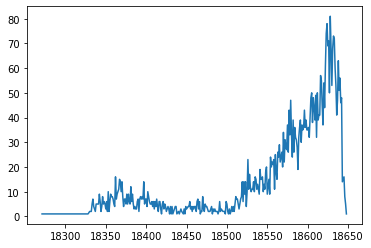

In [49]:
#Number of Fatal outcomes per day 
test = df1[df1.Outcome1 == 1]
a = test.Accurate_Episode_Date.value_counts()
a = a.sort_index()
plt.plot(a.index,a.values);

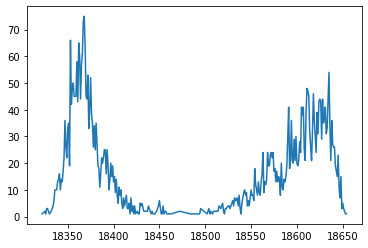

In [50]:
#Number of Resolved outcomes per day 
test = df1[df1.Outcome1 == 0]
a = test.Accurate_Episode_Date.value_counts()
a = a.sort_index()
plt.plot(a.index,a.values);

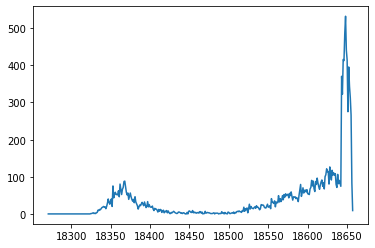

In [51]:
#Number of samples per day 
test = df1
a = test.Accurate_Episode_Date.value_counts()
a = a.sort_index()
plt.plot(a.index,a.values);

# Kaggle:

In [152]:
df_test = pd.read_csv("COVID_dataset_kaggle.csv")

In [153]:
#Missing information:
df_test.isnull().sum()

id                            0
Accurate_Episode_Date         0
Case_Reported_Date            0
Test_Reported_Date           50
Specimen_Date                30
Age_Group                     0
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           2216
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
dtype: int64

In [154]:
#Fill Outbreak related NaNs with 0 and replace 'Yes' with 1:
df_test['Outbreak_Related'] = df_test['Outbreak_Related'].fillna('No')
Outbreak_Related_map = {'Yes':1,'No':0}
df_test = df_test.replace({"Outbreak_Related":Outbreak_Related_map})
df_test['Outbreak_Related'] = df_test['Outbreak_Related'].astype('float32')



In [155]:
#Since missing date information cannot be filled, drop test_reported_date and specimen date:
df_test = df_test.drop(columns=['Test_Reported_Date','Specimen_Date'])

In [156]:
#Replace Age_Group string values with ordinal values:
Age_Group_map = {'<20':1,'20s':2,'30s':3,'40s':4,'50s':5,'60s':6,'70s':7,'80s':8,'90s':9}
df_test = df_test.replace({"Age_Group":Age_Group_map})
df_test['Age_Group'] = df_test['Age_Group'].astype(str) #for indicator feature column

In [157]:
#Converting datetime columns to unix timestamp (in days)
for i in range(len(df_test)):
    df_test.loc[i,['Accurate_Episode_Date']]=(pd.Timestamp(df_test['Accurate_Episode_Date'][i])
                                         -pd.Timestamp("1970-01-01"))//pd.Timedelta('1d')
    df_test.loc[i,['Case_Reported_Date']] = (pd.Timestamp(df_test['Case_Reported_Date'][i])
                                        -pd.Timestamp("1970-01-01"))//pd.Timedelta('1d')

In [158]:
# Method to go from dataframe to tf dataset:
def df_to_dataset1(dataframe, batch_size=32):
  dataframe = dataframe.copy()
  ds = tf.data.Dataset.from_tensor_slices(dataframe.to_dict(orient='list'))
  ds = ds.batch(batch_size)
  return ds

In [159]:
batch_size = 32
test_X = df_to_dataset1(df_test,batch_size=batch_size)

In [160]:
test_y = model.predict(test_X)
test_y = test_y.round(decimals=0)

In [161]:
test_y

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [162]:
pred = []
for i in range(len(test_y)):
    if test_y[i][0] == 1:
        pred.append('Fatal')
    elif test_y[i][1] == 1:
        pred.append('Resolved')
    else:
        pred.append('Not Resolved')

In [163]:
predictions = pd.DataFrame(pred,columns=['Outcome1'])
predictions['id'] = predictions.index

In [164]:
predictions = predictions[['id','Outcome1']]
predictions.to_csv(index=False)

,id,Outcome1
0,0,Fatal
1,1,Resolved
2,2,Not Resolved
3,3,Resolved
4,4,Not Resolved
...,...,...
3699,3699,Not Resolved
3700,3700,Fatal
3701,3701,Not Resolved
3702,3702,Not Resolved


In [166]:
predictions.to_csv('predictions.csv',index=False)